# 使用 PyTorch 实现 MNIST 手写数字识别的 MLP

本 Notebook 使用 PyTorch 实现一个包含三层隐藏层的多层感知机 (MLP)，用于分类 MNIST 手写数字数据集。

In [1]:
pip install torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 MB 1.8 MB/s eta 0:00:0000:0100:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 2.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 2.3 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.2
    Uninstalling sympy-1.13.2:
      Successfully uninstalled sympy-1.13.2
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# 设置随机种子以确保可重复性
torch.manual_seed(42)
np.random.seed(42)

Matplotlib is building the font cache; this may take a moment.


## 1. 加载和预处理 MNIST 数据集

加载 MNIST 数据集并将像素值归一化到 [-1, 1] 范围。

In [3]:
# 定义数据转换
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 加载 MNIST 数据集
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False)

# 打印数据集信息
print(f'训练数据集大小: {len(train_dataset)}')
print(f'测试数据集大小: {len(test_dataset)}')

100%|██████████| 9.91M/9.91M [00:23<00:00, 419kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 29.2kB/s]
100%|██████████| 1.65M/1.65M [00:03<00:00, 447kB/s] 
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.31MB/s]

训练数据集大小: 60000
测试数据集大小: 10000


## 2. 可视化样本数据

展示训练集中的几张样本图像。

/var/folders/xd/1qtnjp4s4kv_9z6x7bq465kw0000gn/T/ipykernel_3315/1162472893.py:12: UserWarning: Glyph 26631 (\N{CJK UNIFIED IDEOGRAPH-6807}) missing from font(s) DejaVu Sans.
  plt.savefig('mnist_samples.png')
/var/folders/xd/1qtnjp4s4kv_9z6x7bq465kw0000gn/T/ipykernel_3315/1162472893.py:12: UserWarning: Glyph 31614 (\N{CJK UNIFIED IDEOGRAPH-7B7E}) missing from font(s) DejaVu Sans.
  plt.savefig('mnist_samples.png')
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26631 (\N{CJK UNIFIED IDEOGRAPH-6807}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 31614 (\N{CJK UNIFIED IDEOGRAPH-7B7E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


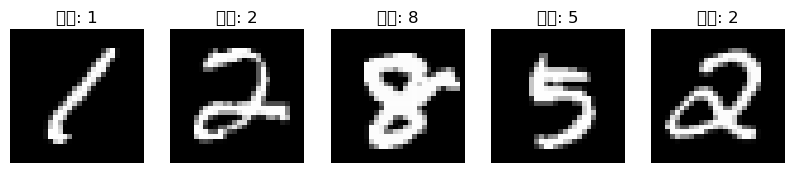

In [4]:
# 获取一些样本图像
dataiter = iter(train_loader)
images, labels = next(dataiter)

# 绘制前 5 张图像
plt.figure(figsize=(10, 2))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(images[i].numpy().squeeze(), cmap='gray')
    plt.title(f'标签: {labels[i].item()}')
    plt.axis('off')
plt.savefig('mnist_samples.png')

## 3. 定义 MLP 模型

创建一个包含三层隐藏层的 MLP：
- 输入层：将 28x28 图像展平为 784 维向量
- 隐藏层 1：256 个神经元，ReLU 激活函数
- 隐藏层 2：128 个神经元，ReLU 激活函数
- 隐藏层 3：64 个神经元，ReLU 激活函数
- 输出层：10 个神经元（对应每个数字），无激活函数（Softmax 在损失函数中处理）

In [6]:
# 定义 MLP 模型
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(784, 256)  # 第一隐藏层
        self.fc2 = nn.Linear(256, 128)  # 第二隐藏层
        self.fc3 = nn.Linear(128, 64)   # 第三隐藏层
        self.fc4 = nn.Linear(64, 10)    # 输出层

    def forward(self, x):
        x = x.view(-1, 784)  # 展平输入
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)  # 输出层无激活函数
        return x

# 初始化模型
model = MLP()

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## 4. 训练模型

在训练数据上训练 MLP，设置 10 个 epoch。

In [7]:
# 训练循环
train_losses = []
train_accuracies = []

for epoch in range(10):
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        optimizer.zero_grad()  # 清零梯度
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    print(f'Epoch {epoch+1}, 损失: {epoch_loss:.4f}, 准确率: {epoch_acc:.2f}%')

Epoch 1, 损失: 0.4038, 准确率: 87.73%
Epoch 2, 损失: 0.1717, 准确率: 94.73%
Epoch 3, 损失: 0.1249, 准确率: 96.09%
Epoch 4, 损失: 0.1016, 准确率: 96.93%
Epoch 5, 损失: 0.0829, 准确率: 97.37%
Epoch 6, 损失: 0.0741, 准确率: 97.62%
Epoch 7, 损失: 0.0644, 准确率: 97.91%
Epoch 8, 损失: 0.0593, 准确率: 98.12%
Epoch 9, 损失: 0.0562, 准确率: 98.11%
Epoch 10, 损失: 0.0474, 准确率: 98.44%


## 5. 评估模型

在测试集上评估模型，并绘制训练损失和准确率曲线。

测试准确率: 97.28%


/var/folders/xd/1qtnjp4s4kv_9z6x7bq465kw0000gn/T/ipykernel_3315/3061052917.py:34: UserWarning: Glyph 25439 (\N{CJK UNIFIED IDEOGRAPH-635F}) missing from font(s) DejaVu Sans.
  plt.savefig('training_metrics.png')
/var/folders/xd/1qtnjp4s4kv_9z6x7bq465kw0000gn/T/ipykernel_3315/3061052917.py:34: UserWarning: Glyph 22833 (\N{CJK UNIFIED IDEOGRAPH-5931}) missing from font(s) DejaVu Sans.
  plt.savefig('training_metrics.png')
/var/folders/xd/1qtnjp4s4kv_9z6x7bq465kw0000gn/T/ipykernel_3315/3061052917.py:34: UserWarning: Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from font(s) DejaVu Sans.
  plt.savefig('training_metrics.png')
/var/folders/xd/1qtnjp4s4kv_9z6x7bq465kw0000gn/T/ipykernel_3315/3061052917.py:34: UserWarning: Glyph 32451 (\N{CJK UNIFIED IDEOGRAPH-7EC3}) missing from font(s) DejaVu Sans.
  plt.savefig('training_metrics.png')
/var/folders/xd/1qtnjp4s4kv_9z6x7bq465kw0000gn/T/ipykernel_3315/3061052917.py:34: UserWarning: Glyph 20934 (\N{CJK UNIFIED IDEOGRAPH-51C6}) missing from

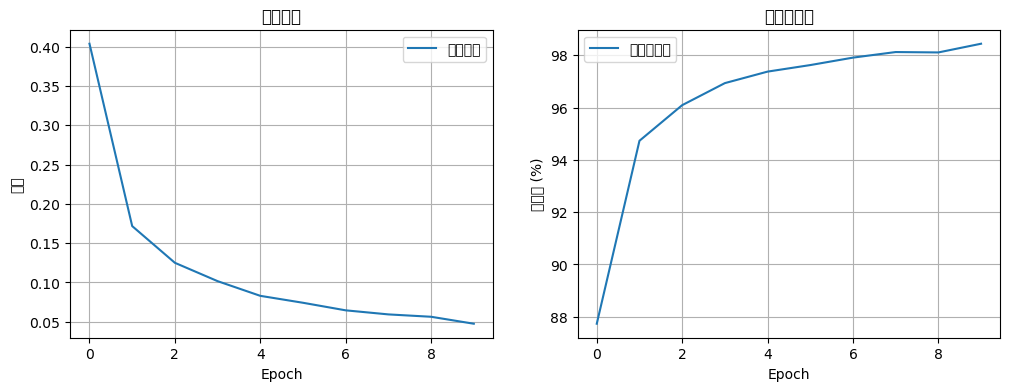

In [8]:
# 在测试集上评估
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'测试准确率: {test_accuracy:.2f}%')

# 绘制训练损失和准确率
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='训练损失')
plt.title('训练损失')
plt.xlabel('Epoch')
plt.ylabel('损失')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='训练准确率')
plt.title('训练准确率')
plt.xlabel('Epoch')
plt.ylabel('准确率 (%)')
plt.legend()
plt.grid(True)

plt.savefig('training_metrics.png')

## 6. 进行预测

在几张测试图像上测试模型并显示预测结果。

/var/folders/xd/1qtnjp4s4kv_9z6x7bq465kw0000gn/T/ipykernel_3315/644112640.py:15: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from font(s) DejaVu Sans.
  plt.savefig('predictions.png')
/var/folders/xd/1qtnjp4s4kv_9z6x7bq465kw0000gn/T/ipykernel_3315/644112640.py:15: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from font(s) DejaVu Sans.
  plt.savefig('predictions.png')
/var/folders/xd/1qtnjp4s4kv_9z6x7bq465kw0000gn/T/ipykernel_3315/644112640.py:15: UserWarning: Glyph 30495 (\N{CJK UNIFIED IDEOGRAPH-771F}) missing from font(s) DejaVu Sans.
  plt.savefig('predictions.png')
/var/folders/xd/1qtnjp4s4kv_9z6x7bq465kw0000gn/T/ipykernel_3315/644112640.py:15: UserWarning: Glyph 23454 (\N{CJK UNIFIED IDEOGRAPH-5B9E}) missing from font(s) DejaVu Sans.
  plt.savefig('predictions.png')
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from font(s) DejaVu Sans.
  fig.ca

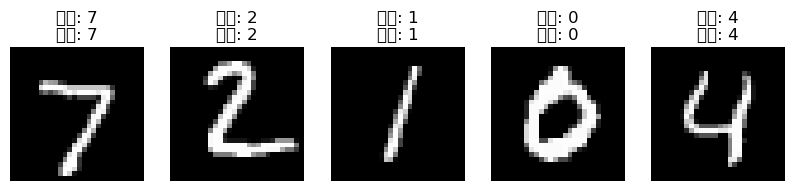

In [9]:
# 预测前 5 张测试图像
model.eval()
dataiter = iter(test_loader)
images, labels = next(dataiter)
outputs = model(images[:5])
_, predicted = torch.max(outputs, 1)

# 显示预测结果
plt.figure(figsize=(10, 2))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(images[i].numpy().squeeze(), cmap='gray')
    plt.title(f'预测: {predicted[i].item()}\n真实: {labels[i].item()}')
    plt.axis('off')
plt.savefig('predictions.png')